In [1]:
# Useful starting lines - HARD NECESSAIRE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [335]:
tempou=boxplotData[-1]
boxplotData=[]
boxplotData.append(temp[0][:-1])
boxplotData.append(tempou)

In [377]:
# HARD NECESSAIRE
from proj1_helpers import *
testY,testX,idTest=load_csv_data("../../dataset/test.csv", sub_sample=False)
trainY,trainX,idTrain=load_csv_data("../../dataset/train.csv", sub_sample=False)

In [317]:
newFeature=(trainX==-999).sum(axis=1)
newFeatureTest=(testX==-999).sum(axis=1)

In [378]:
# NECESSAIRE (MAIS TEST AVEC ET SANS EST UN PLUS)
trainX[trainX==-999]=np.nan
testX[testX==-999]=np.nan
meanTrain=np.nanmean(trainX,axis=0)
meanTest=np.nanmean(testX,axis=0)
indsTrain = np.where(np.isnan(trainX))
indsTest = np.where(np.isnan(testX))
trainX[indsTrain]=np.take(meanTrain,indsTrain[1])
testX[indsTest]=np.take(meanTest,indsTest[1])

Find linearly dependant column

In [319]:
# DOIT FAIRE TEST AVEC ET SANS
for i in range(trainX.shape[1]):
    if(not np.any(trainX[:,i]<=0)):
        trainX[:,i]=np.log(trainX[:,i])
    #else:
        #trainX[:,i]=np.log(trainX[:,i]-np.min(trainX[:,i])+1)
for i in range(testX.shape[1]):
    if(not np.any(testX[:,i]<=0)):
        testX[:,i]=np.log(testX[:,i])
    #else:
        #testX[:,i]=np.log(testX[:,i]-np.min(testX[:,i])+1)

In [67]:
trainX=np.c_[trainX,newFeature]
testX=np.c_[testX,newFeatureTest]

In [379]:
# NECESSAIRE (MAIS TEST AVEC ET SANS EST UN PLUS)
meanTrain=np.nanmean(trainX,axis=0)
meanTest=np.nanmean(testX,axis=0)
stdTrain=np.std(trainX,axis=0)
stdTest=np.std(testX,axis=0)
trainX=(trainX-meanTrain)/stdTrain
testX=(testX-meanTest)/stdTest

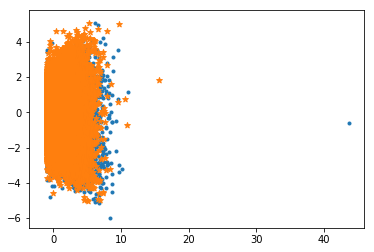

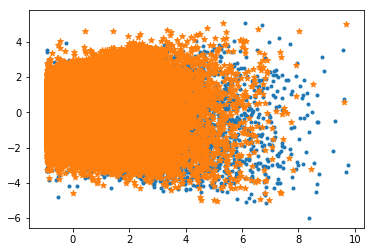

In [70]:
#remove outliers - HARD NECESSAIRE (FUNCTION)
def reject_outliers(data, m=10):
    newData=np.copy(data)
    ind=abs(data - np.mean(data,axis=0)) > m * np.std(data,axis=0)
    newData[ind]=0
    return newData
    
deg1=3
deg2=10
    
bla=reject_outliers(trainX)
plt.scatter(trainX[np.where(trainY==1),deg1],trainX[np.where(trainY==1),deg2],marker='.')
plt.scatter(trainX[np.where(trainY==-1),deg1],trainX[np.where(trainY==-1),deg2],marker='*')
plt.figure()
plt.scatter(bla[np.where(trainY==1),deg1],bla[np.where(trainY==1),deg2],marker='.')
plt.scatter(bla[np.where(trainY==-1),deg1],bla[np.where(trainY==-1),deg2],marker='*')

In [321]:
# NECESSAIRE (MAIS TEST AVEC ET SANS EST UN PLUS)
trainX=reject_outliers(trainX)
testX=reject_outliers(testX)

In [193]:
# NEED ONLY WITH GD
initial_w=np.zeros((30,))
initial_w0=np.zeros((31,))
max_iters=500
gamma=3e-7
#lambda_=10
#degree=4

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


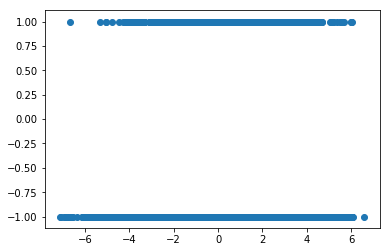

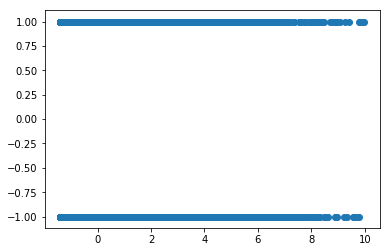

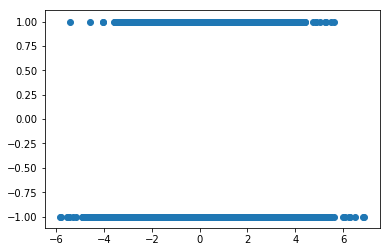

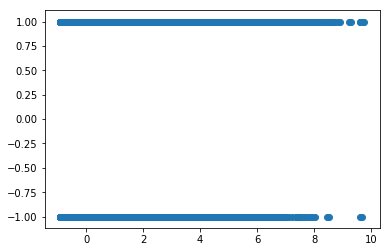

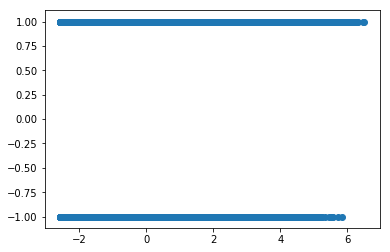

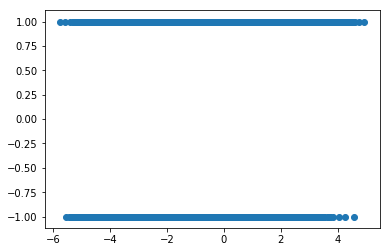

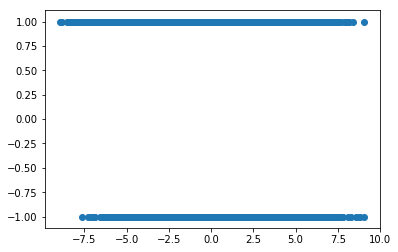

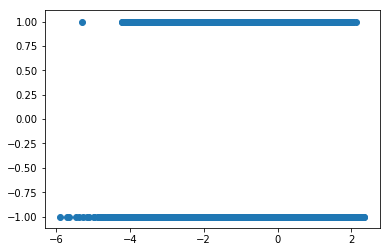

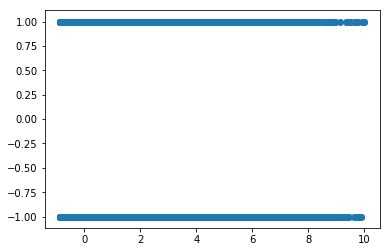

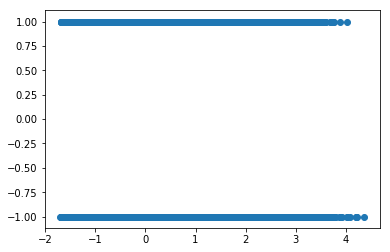

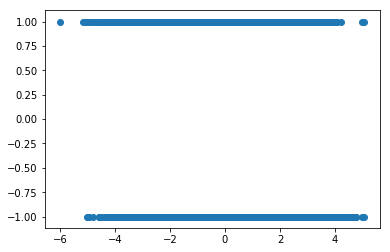

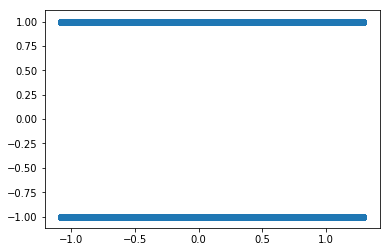

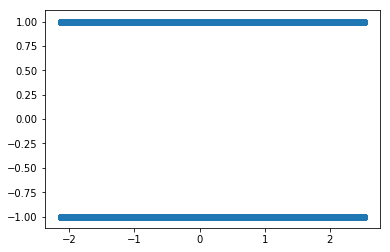

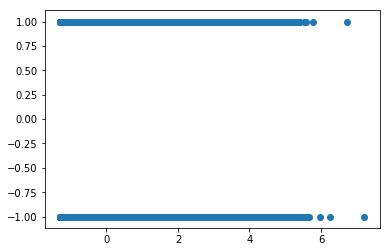

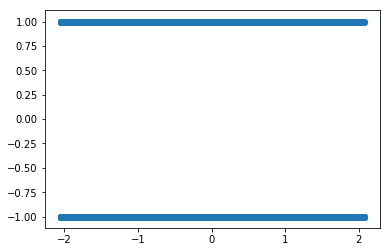

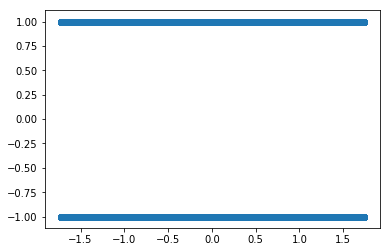

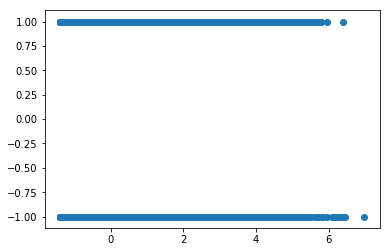

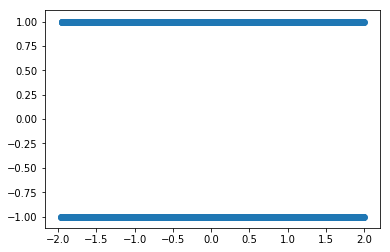

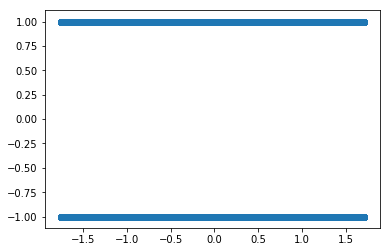

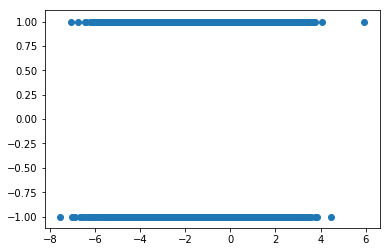

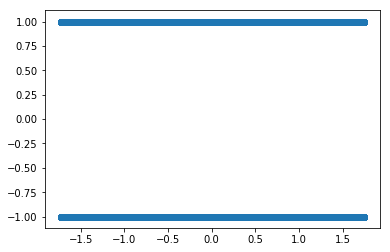

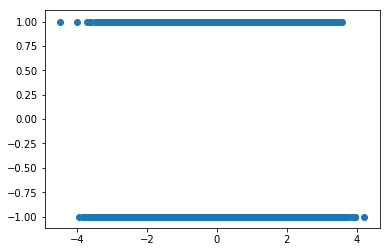

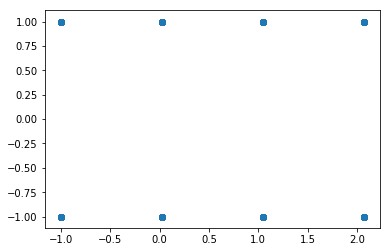

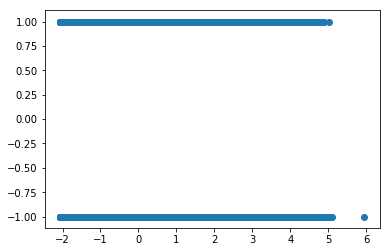

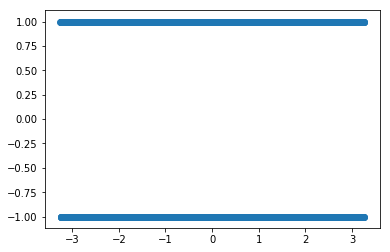

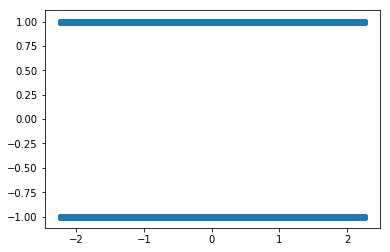

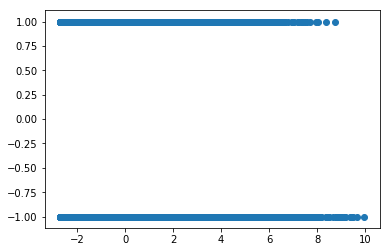

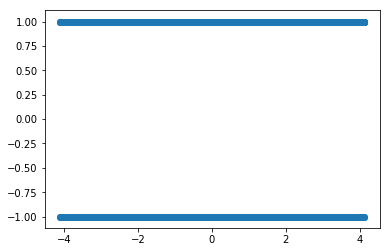

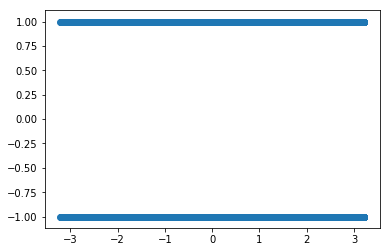

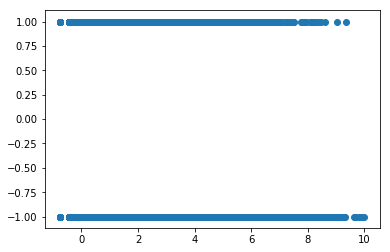

In [8]:
# USELESS FOR TEST
# 4,6,7,11,12,14,15,18,20,22,24,25,27,28 is useless?
for i in range(trainX.shape[1]):
    plt.figure(i)
    plt.scatter(trainX[:,i],trainY[:])

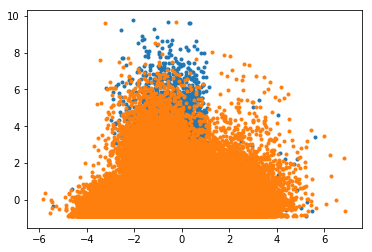

In [9]:
#USELESS FOR TEST
deg1=2
deg2=3
plt.scatter(trainX[np.where(trainY==1),deg1],trainX[np.where(trainY==1),deg2],marker='.')
plt.scatter(trainX[np.where(trainY==-1),deg1],trainX[np.where(trainY==-1),deg2],marker='.')

Need to make a train-test split of train data to cross-validate, with a symmetric number of y

In [10]:
#USELESS FOR PRELIMINARY TEST 
np.random.seed(2)
from split_data import *
tr_trainX,tr_trainY,tr_testX,tr_testY=split_data(trainX,trainY,0.5)

In [10]:
# HARD NECESSAIRE
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [11]:
#HARD NECESSAIRE
from costs import compute_mse

def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""
    test_ind=k_indices[k]
    train_ind=k_indices[[i for i in range(k_indices.shape[0]) if i!=k]]
    train_ind=train_ind.reshape(-1)
    
    y_train=y[train_ind]
    y_test=y[test_ind]
    x_train=x[train_ind,:]
    x_test=x[test_ind,:]

    #tx_train=build_poly(x_train,degree)
    #tx_test=build_poly(x_test,degree)

    w,loss_tr=ridge_regression(y_train,x_train,lambda_)

    loss_te=compute_mse(y_test,x_test,w)
    return loss_tr, loss_te

In [12]:
#HARD NECESSAIRE
def reg_log_cross_validation(y, tx, k_indices, k, lambda_,gamma):
    """return the loss of ridge regression."""
    test_ind=k_indices[k]
    train_ind=k_indices[[i for i in range(k_indices.shape[0]) if i!=k]]
    train_ind=train_ind.reshape(-1)
    
    y_train=y[train_ind]
    y_test=y[test_ind]
    tx_train=tx[train_ind,:]
    tx_test=tx[test_ind,:]

    w,loss_tr=reg_logistic_regression(y_train,tx_train,lambda_,np.zeros(tx.shape[1]),100,gamma)
    loss_te=compute_sig_loss2(y_test,tx_test,w)+lambda_/2*np.linalg.norm(w)
    return loss_tr, loss_te

In [380]:
#HARD NECESSAIRE
from costs import compute_mse

def cross_validation_GD(y, x, k_indices, k, gamma):
    """return the loss of ridge regression."""
    test_ind=k_indices[k]
    train_ind=k_indices[[i for i in range(k_indices.shape[0]) if i!=k]]
    train_ind=train_ind.reshape(-1)
    
    y_train=y[train_ind]
    y_test=y[test_ind]
    x_train=x[train_ind,:]
    x_test=x[test_ind,:]

    #tx_train=build_poly(x_train,degree)
    #tx_test=build_poly(x_test,degree)

    w,loss_tr=least_squares_GD(y_train,x_train,np.zeros((x_train.shape[1],)),500,gamma)

    loss_te=compute_mse(y_test,x_test,w)
    return loss_tr, loss_te

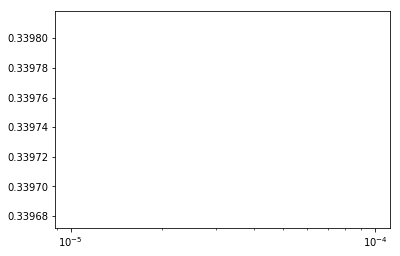

In [106]:
# NOPE
degree=4
seed = 1
k_fold = 8
lambdas= [0,8.2864277285468429e-05]#np.logspace(-10, 0, 50)
k_indices = build_k_indices(trainY, k_fold, seed)


losses=[]
losses_te=[]
tx = build_poly(trainX,degree)

for lambda_ in lambdas:
    temp_tr=[]
    temp_te=[]
    for k in range(k_fold):
        tr,te=cross_validation(trainY,tx,k_indices,k,lambda_)
        temp_tr.append(tr)
        temp_te.append(te)
    boxplotData.append(temp_te)
    losses.append(np.mean(temp_tr))
    losses_te.append(np.mean(temp_te))
    #add np.std test pour rapport
plt.semilogx(lambdas,losses)
plt.semilogx(lambdas,losses_te)

In [100]:
# NOPE
lambdas[np.argmin(losses_te)]

8.2864277285468429e-05

In [13]:
# HARD NECESSAIRE
def build_poly(tx,degree):
    poly = np.ones((len(tx), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(tx, deg)]
    return poly

In [14]:
# NOPE
def build_cross_poly(tx):
    "add cross influence of second order. Other will be estimated as low"
    poly = np.ones((tx.shape[0], 1))
    for feat in range(tx.shape[1]):
        for sec in range(feat+1,tx.shape[1]):
            poly = np.c_[poly, tx[:,feat]*tx[:,sec]]
    return poly

In [69]:
# MAYBE USELESS?
degree=1
tx=build_poly(trainX,degree)

In [75]:
#NOPE
tx2=build_cross_poly(trainX)

In [197]:
# FUNC1
from costs import *
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e=y-np.dot(tx,w)
    grad=-tx.T.dot(e)/y.shape[0]
    return grad

def compute_hessian(y, tx, w):
    prev = 1.0 / (1 + np.exp(w.dot(tx)))
    prevv = np.diag(prev.T[0])
    ret = prevv * (1-prevv)
    return tx.T.dot(r).dot(tx)

def least_squares_GD(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad=compute_gradient(y,tx,w)
        old_loss=compute_mse(y,tx,w)
        w=w-gamma*grad
        loss=compute_mse(y,tx,w)
        if (old_loss-loss)<1e-8:
            break
    return w, loss

In [16]:
# FUNC2
from helpers import batch_iter
def least_squares_SGD(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    batch_size=1
    for n_iter in range(max_iters):
        for yBatch,txBatch in batch_iter(y, tx, batch_size):
            grad=compute_gradient(yBatch,txBatch,w)
            w=w-gamma*grad
            loss=compute_mse(y,tx,w)
    return w, loss

In [17]:
# FUNC3
from costs import *
def least_squares(y,tx):
    if len(y)!=tx.shape[0]:
        raise ValueError("y and tx must have the same length")
    w = np.linalg.solve(np.dot(tx.transpose(), tx), np.dot(tx.transpose(), y))
    loss=compute_mse(y,tx,w)
    return w, loss

In [18]:
# FUNC4
from costs import *
def ridge_regression(y,tx,lambda_):
    w=np.linalg.solve(tx.T.dot(tx)+2*tx.shape[0]*lambda_*np.eye(tx.shape[1]),tx.T.dot(y))
    loss=compute_mse(y,tx,w)
    return w, loss

In [19]:
# HARD NECESSAIRE
def sigmoid(t):
    """apply sigmoid function on t."""
    y=1./(1+np.exp(-t))
    return y

def compute_sig_loss(y,tx,w):
    y=(y+1)/2
    pred = sigmoid(tx.dot(w))
    #sum=0
    #for i in range(len(y)):
    #    temp=(1-y)[i]*np.log(1-pred)[i]
    #    sum+=temp
    #    if np.isnan(temp):
    #        print((1-y)[i])
    #        print(np.log(1-pred)[i])
        #print("sum: "+str(sum))
    #print((1-y)*np.log(1 - pred))
    #print(np.sum((1-y)*np.log(1 - pred)))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    #print(loss)
    loss/=len(y)
    return np.squeeze(- loss)

def compute_sig_loss2(y,tx,w):
    y=(y+1)/2
    loss=np.log(1+np.exp(tx.dot(w)))
    loss/=len(y)
    #if(tx.shape[1]>=(1+4*30)):
    #    print(loss)
    #    print(loss/len(y))
    loss=np.sum(loss)
    loss-=y.T.dot(tx).dot(w)/len(y)
    #loss/=len(y)
    return loss

def compute_sig_gradient(y,tx,w):
    y=(y+1)/2
    #print(sigmoid(tx.dot(w))-y)
    return tx.T.dot(sigmoid(tx.dot(w))-y)

In [20]:
# FUNC5
def logistic_regression(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad=compute_sig_gradient(y,tx,w)
        #print("grad: "+str(np.linalg.norm(grad)))
        old_loss=compute_sig_loss2(y,tx,w)
        #print(old_loss)
        w-=gamma*grad
        #print(w)
        loss=compute_sig_loss2(y,tx,w)
        #print(loss-old_loss)
        if n_iter%100==0:
            if n_iter==0:
                print("-------------- degree "+str((tx.shape[1]-1)/30)+" --------------")
            print(loss)
        if old_loss-loss<1e-10:
            break
    return w, loss

In [257]:
# FUNC6
def reg_logistic_regression(y,tx,lambda_,initial_w,max_iters,gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad=compute_sig_gradient(y,tx,w)+2*lambda_*w
        #print(grad)
        old_loss=compute_sig_loss2(y,tx,w)+lambda_/2*np.linalg.norm(w)/len(y)
        w-=gamma*grad
        loss=compute_sig_loss2(y,tx,w)+lambda_/2*np.linalg.norm(w)/len(y)
        #print(loss)
        if n_iter%100==0:
            print(loss)
        if old_loss-loss<1e-10:
            break
    return w, loss

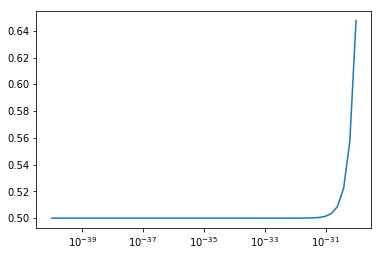

In [384]:
# FINC GAMMA (GD)
degree=9
tx=build_poly(trainX,degree)
initial_w=np.zeros((tx.shape[1],))
gammas=np.logspace(-40,-30,50)
losses=[]
for gamma in gammas:
    w,loss=least_squares_GD(trainY,tx,initial_w,10,gamma)
    losses.append(loss)
plt.semilogx(gammas,losses)

In [385]:
# KEEP GAMMA
gamma=gammas[np.argmin(losses)]
print(gamma)

3.55648030622e-33


In [386]:
# NOT TEST, EXAMPLE OF GD USE
degree=9
tx=build_poly(trainX,degree)
initial_w=np.zeros((tx.shape[1],))
w,loss=least_squares_GD(trainY,tx,initial_w,max_iters,gamma)
print(loss)

0.499998000001


In [41]:
# NOT TEST, EXAMPLE OF LOG_GD USE
degree=1
tx=build_poly(tr_trainX,degree)
w,loss=logistic_regression(tr_trainY,tx,np.zeros((31,)),500,0.000006)
print(loss)

0.603731505047
0.494943791154
0.489209934087
0.487215356525
0.486447887518
0.486133953513


1e-06
-------------- degree 1.0 --------------
0.673443205435
0.51273767139
0.505770435409
0.501948542624
0.499104197355
0.496861794978
0.495054750095
0.49358082359
0.492368835
0.491366127154
1e-07
-------------- degree 2.0 --------------
0.68133778255
0.502933280144
0.475195842445
0.4617458162
0.453626290352
0.448193159811
0.444334874708
0.441484158945
0.439314605804
0.437623504108
1e-08
-------------- degree 3.0 --------------
0.689005422003
0.592863545757
0.560777752257
0.543019184251
0.531291240939
0.522621452422
0.515715914718
0.509946838896
0.504975709705
0.500602602763
1e-09
-------------- degree 4.0 --------------
0.6878257932
0.621904220063
0.601268605325
0.587856781679
0.577998126945
0.570324092219
0.56413508274
0.559015146601
0.554694594753
0.550988489509
1e-10
-------------- degree 5.0 --------------
0.689603721846
1e-11
-------------- degree 6.0 --------------
0.705258090187
1e-12
-------------- degree 7.0 --------------
0.817773300806


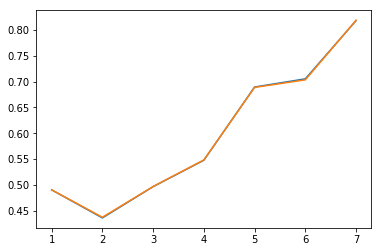

In [137]:
# NOT TEST, EXAMPLE OF LOG_GD USE (DEGREE)
losses=[]
losses_te=[]
ws=[]
degrees=range(1,8)
for degree in degrees:
    tx=build_poly(tr_trainX,degree)
    tx_test=build_poly(tr_testX,degree)
    gamma=1e-5
    gamma/=np.power(10,degree)
    print(gamma)
    w,loss=logistic_regression(tr_trainY,tx,np.zeros((1+degree*30,)),1000,gamma)
    losses.append(loss)
    ws.append(w)
    losses_te.append(compute_sig_loss2(tr_testY,tx_test,w))
plt.plot(degrees,losses)
plt.plot(degrees,losses_te)

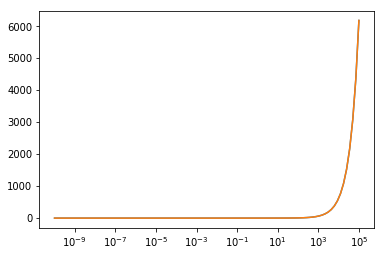

In [139]:
# NOT TEST, EXAMPLE OF REG_LOG_GD USE (LAMBDA)
degree=2
tx=build_poly(tr_trainX,degree)
tx_test=build_poly(tr_testX,degree)
losses=[]
losses_te=[]
ws=[]
lambdas=np.logspace(-10,3,100)
for lambda_ in lambdas:
    w,loss=reg_logistic_regression(tr_trainY,tx,lambda_,np.zeros((1+degree*30,)),100,1e-6)
    losses.append(loss)
    ws.append(w)
    losses_te.append(compute_sig_loss2(tr_testY,tx_test,w)+lambda_/2*np.linalg.norm(w))
plt.semilogx(lambdas,losses)
plt.semilogx(lambdas,losses_te)

In [142]:
lambda_=lambdas[np.argmin(losses_te)]
w=ws[np.argmin(losses_te)]
print(np.min(losses_te))
print(lambda_)
print(w)

0.437477211499
1e-10
[-0.06036299  0.29846599 -0.47463496  0.16373836  0.1121642   0.06162117
  0.04680837 -0.06019233  0.24076895 -0.06577156  0.09925196 -0.23839495
  0.22758108  0.15635102  0.33204321 -0.00367404 -0.00072087  0.03266479
  0.00222619 -0.00556971 -0.08358119  0.00268071  0.02920044 -0.0518172
  0.15725812 -0.00109394  0.00620598  0.06490763  0.00435199 -0.00237954
  0.02869654 -0.39504389  0.08723381 -0.35309043  0.13250932  0.04153907
  0.07462178 -0.01648463 -0.19630983  0.02296261 -0.04644717 -0.02378194
  0.11499736  0.02629293 -0.04566492 -0.11662307 -0.04270435  0.03350715
 -0.19280865 -0.05671041  0.05754729 -0.04000782 -0.08064854 -0.13304036
 -0.09496215  0.16145788 -0.06013862 -0.0171308   0.05574295 -0.02061584
 -0.01809677]


In [141]:
degree=2
tx=build_poly(trainX,degree)
w,loss=logistic_regression(trainY,tx,np.zeros((1+degree*30,)),1000,1e-6)

-------------- degree 2.0 --------------
0.590910730248


In [44]:
# NOT TEST, EXAMPLE OF LEAST_SQUARES
w,loss=least_squares(trainY,trainX)
print(loss)

0.379950528954


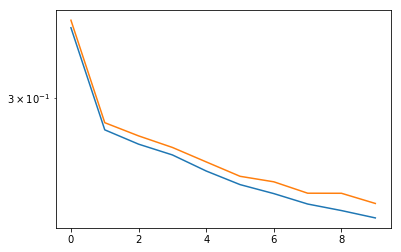

In [48]:
# higher degree give worst results
degrees=range(0,10)
losses=[]
losses_te=[]
for degree in degrees:
    tx=np.c_[build_poly(tr_trainX,degree),build_cross_poly(tr_trainX)[:,1:]]
    tx_trtest=np.c_[build_poly(tr_testX,degree),build_cross_poly(tr_testX)[:,1:]]
    w=np.zeros((tx.shape[1],))
    w,loss=least_squares(tr_trainY,tx)
    losses.append(loss)
    losses_te.append(compute_mse(tr_testY,tx_trtest,w))
plt.semilogy(degrees,losses)
plt.semilogy(degrees,losses_te)

In [404]:
k_fold=8
k_indices = build_k_indices(trainY, k_fold, seed)
degree=3
#lambda_=0.#0014563484775
tx = build_poly(trainX,degree)
temp_tr=[]
temp_te=[]
for k in range(k_fold):
    tr,te=cross_validation(trainY,tx,k_indices,k,lambda_)
    temp_tr.append(tr)
    temp_te.append(te)
#boxplotData[0]=temp_te.copy()
boxplotData.append(temp_te)

In [302]:
k_fold=8
degree=2
lambda_=0.007
gamma=6e-18
tx = build_poly(trainX,degree)
temp_tr=[]
temp_te=[]
for k in range(k_fold):
    print("next fold")
    tr,te=reg_log_cross_validation(trainY,tx,k_indices,k,lambda_,gamma)
    print(tr)
    temp_tr.append(tr)
    temp_te.append(te)
boxplotData.append(temp_te)

next fold
0.659729222609
0.589504580082
next fold
0.660246140423
0.590047883088
next fold
0.659776888566
0.589200781201
next fold
0.659763784275
0.589870439086
next fold
0.659856351169
0.589748051969
next fold
0.659974403511
0.590041217707
next fold
0.659686342896
0.589471188013
next fold
0.659751400707
0.589195557423


In [376]:
k_fold=8
degree=9
#gamma=3e-7
tx = build_poly(trainX,degree)
temp_tr=[]
temp_te=[]
for k in range(k_fold):
    tr,te=cross_validation_GD(trainY,tx,k_indices,k,gamma)
    temp_tr.append(tr)
    temp_te.append(te)
boxplotData.append(temp_te)

KeyboardInterrupt: 

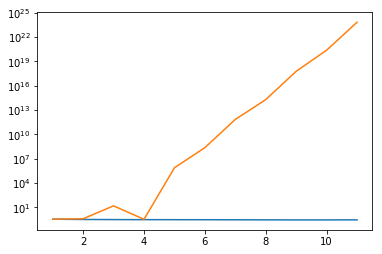

In [387]:
# EXAMPLE OF CROSS-VALIDATION WITH STD
## graph for report with mean and stds in this case
degrees=range(1,12)
seed = 1
k_fold = 8
lambda_=0
k_indices = build_k_indices(trainY, k_fold, seed)
gamma=3e-7

losses=[]
losses_te=[]
stds=[]

for degree in degrees:
    tx = build_poly(trainX,degree)
    #tx=np.c_[tx,tx2[:,1:]]
    temp_tr=[]
    gamma/=10
    temp_te=[]
    for k in range(k_fold):
        tr,te=cross_validation(trainY,tx,k_indices,k,lambda_)
        temp_tr.append(tr)
        temp_te.append(te)
    losses.append(np.mean(temp_tr))
    losses_te.append(np.mean(temp_te))
    stds.append(np.std(temp_te))
plt.semilogy(degrees,losses)
plt.semilogy(degrees,losses_te)

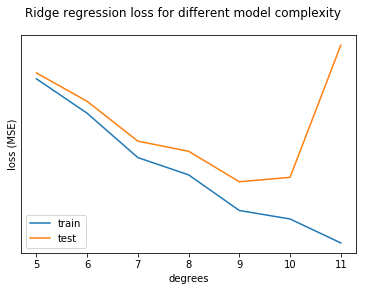

In [73]:
plt.semilogy(degrees,losses,label="train")
plt.semilogy(degrees,losses_te,label="test")
plt.xlabel("degrees")
plt.ylabel("loss (MSE)")
plt.suptitle("Ridge regression loss for different model complexity")
plt.legend()

plt.savefig('degree_cross_valid.eps', bbox_inches='tight')

In [74]:
np.array(stds)/np.array(losses_te)

array([ 0.00286465,  0.00453247,  0.00773021,  0.01284611,  0.0154263 ,
        0.01872718,  0.10509889])

In [388]:
degree=degrees[np.argmin(losses_te)]
print(degree)

4


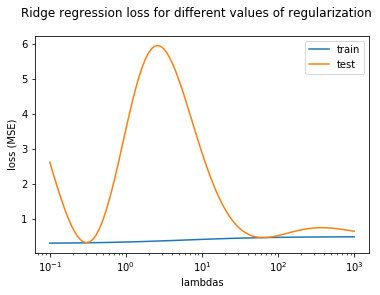

In [402]:
# EXAMPLE OF CROSS-VALIDATION WITH STD
degree=3
lambdas= np.logspace(-1, 3, 100)
k_fold=4
k_indices = build_k_indices(trainY, k_fold, seed)

losses=[]
losses_te=[]
stds=[]
tx = build_poly(trainX,degree)

for lambda_ in lambdas:
    temp_tr=[]
    temp_te=[]
    for k in range(k_fold):
        tr,te=cross_validation(trainY,tx,k_indices,k,lambda_)
        temp_tr.append(tr)
        temp_te.append(te)
    losses.append(np.mean(temp_tr))
    losses_te.append(np.mean(temp_te))
    stds.append(np.std(temp_te))
plt.semilogx(lambdas,losses,label="train")
plt.semilogx(lambdas,losses_te,label="test")
plt.xlabel("lambdas")
plt.ylabel("loss (MSE)")
plt.suptitle("Ridge regression loss for different values of regularization")
plt.legend()

#plt.savefig('lambdas_cross_valid.eps', bbox_inches='tight')

In [80]:
np.array(stds)/np.array(losses_te)

array([ 0.01543514,  0.01543652,  0.01543809,  0.01543986,  0.01544185,
        0.01544406,  0.0154465 ,  0.01544917,  0.01545208,  0.01545522,
        0.01545857,  0.01546212,  0.01546585,  0.01546972,  0.01547373,
        0.01547784,  0.01548204,  0.01548632,  0.01549067,  0.0154951 ,
        0.01549961,  0.01550423,  0.01550898,  0.01551387,  0.01551894,
        0.01552422,  0.01552972,  0.01553544,  0.01554141,  0.0155476 ,
        0.015554  ,  0.01556057,  0.01556729,  0.01557409,  0.01558094,
        0.01558779,  0.01559457,  0.01560126,  0.01560782,  0.01561423,
        0.01562047,  0.01562655,  0.01563246,  0.01563823,  0.0156439 ,
        0.0156495 ,  0.01565508,  0.0156607 ,  0.01566644,  0.01567237,
        0.0156786 ,  0.01568522,  0.01569233,  0.01570007,  0.01570857,
        0.01571795,  0.01572837,  0.01573997,  0.01575289,  0.01576728,
        0.01578326,  0.01580091,  0.01582027,  0.0158413 ,  0.01586385,
        0.01588762,  0.01591211,  0.01593661,  0.01596007,  0.01

In [403]:
lambda_=lambdas[np.argmin(losses_te)]
print(lambda_)

0.305385550883


----- degree 1 -----
----- fold 0 -----
0.67804468072
----- fold 1 -----
0.678172798921
----- fold 2 -----
0.678173604964
----- fold 3 -----
0.678118555549
----- degree 2 -----
----- fold 0 -----
0.684333351474
----- fold 1 -----
0.684208673765
----- fold 2 -----
0.684280404574
----- fold 3 -----
0.684200483198
----- degree 3 -----
----- fold 0 -----
0.689872185219
----- fold 1 -----
0.6899229128
----- fold 2 -----
0.689979508246
----- fold 3 -----
0.689922490709
----- degree 4 -----
----- fold 0 -----
0.688776145659
----- fold 1 -----
0.688795400473
----- fold 2 -----
0.688913922905
----- fold 3 -----
0.688862979321
----- degree 5 -----
----- fold 0 -----
0.689326929365
----- fold 1 -----
0.689425750599
----- fold 2 -----
0.689337648895
----- fold 3 -----
0.689615851342
----- degree 6 -----
----- fold 0 -----


c:\python35\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


nan
----- fold 1 -----
nan
----- fold 2 -----
nan
----- fold 3 -----
nan
----- degree 7 -----
----- fold 0 -----
0.693130261201
----- fold 1 -----
0.693132484024
----- fold 2 -----
0.693132308608
----- fold 3 -----
0.6931330914
----- degree 8 -----
----- fold 0 -----
0.693065729834
----- fold 1 -----
0.693074300536
----- fold 2 -----
0.693078570421
----- fold 3 -----
0.693082241488
----- degree 9 -----
----- fold 0 -----
0.692816606132
----- fold 1 -----
0.692861729814
----- fold 2 -----
0.692831312815
----- fold 3 -----
0.692890922665


ValueError: x and y must have same first dimension, but have shapes (9,) and (18,)

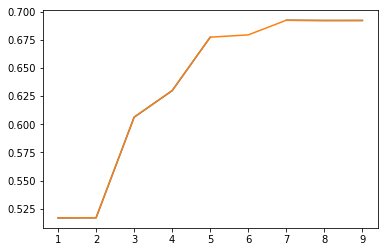

In [41]:
# NOT TEST, EXAMPLE OF REG_LOG_GD USE (LAMBDA)
degrees=range(1,10)
seed = 1
k_fold = 4
lambda_=0
k_indices = build_k_indices(trainY, k_fold, seed)

losses=[]
losses_te=[]
stds=[]
for degree in degrees:
    print("----- degree "+str(degree)+" -----")
    gamma=5e-6
    gamma/=np.power(10,degree)
    if degree>6:
        gamma/=10000
    tx=build_poly(trainX,degree)
    temp_tr=[]
    temp_te=[]
    for k in range(k_fold):
        print("----- fold "+str(k)+" -----")
        tr,te=reg_log_cross_validation(trainY,tx,k_indices,k,lambda_,gamma)
        temp_tr.append(tr)
        temp_te.append(te)
    losses.append(np.mean(temp_tr))
    losses_te.append(np.mean(temp_te))
    stds.append(np.std(temp_te))
plt.plot(degrees,losses)
plt.plot(degrees,losses_te)
plt.plot(degrees,losses_te+stds)
plt.plot(degrees,losses_te-stds)
degree=degrees[np.argmin(losses_te)]
print(degree)

0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762325
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590433
0.643263331325
0.642710331414
0.642741762326
0.642783083649
0.642886875011
0.642674289149
0.642679012441
0.642788590443
0.643263331335
0.64271033

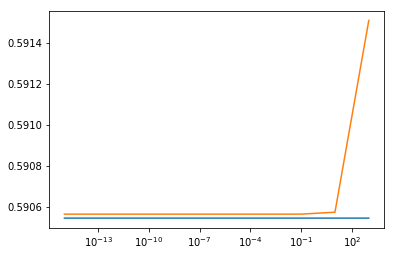

In [303]:
# NOT TEST, EXAMPLE OF REG_LOG_GD USE (LAMBDA)
degree=2
gamma=5e-18
#gamma/=np.power(10,degree)
tx=build_poly(trainX,degree)
losses=[]
losses_te=[]
lambdas=np.logspace(-15,3,10)
for lambda_ in lambdas:
    temp_tr=[]
    temp_te=[]
    for k in range(k_fold):
        tr,te=reg_log_cross_validation(trainY,tx,k_indices,k,lambda_,gamma)
        temp_tr.append(tr)
        temp_te.append(te)
    losses.append(np.mean(temp_tr))
    losses_te.append(np.mean(temp_te))
plt.semilogx(lambdas,losses)
plt.semilogx(lambdas,losses_te)
lambda_=lambdas[np.argmin(losses_te)]
print(lambda_)
print(np.min(losses_te))

0.279343893498


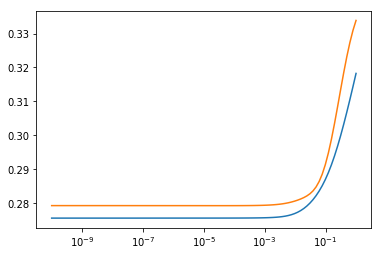

In [50]:
degree=8
tx=build_poly(tr_trainX,degree)
tx_trtest=build_poly(tr_testX,degree)
lambdas= np.logspace(-10, 0, 100)
losses=[]
losses_te=[]
ws=[]
for lambda_ in lambdas:
    w,loss=ridge_regression(tr_trainY,tx,lambda_)
    losses.append(loss)
    losses_te.append(compute_mse(tr_testY,tx_trtest,w))
    ws.append(w)
plt.semilogx(lambdas,losses)
plt.semilogx(lambdas,losses_te)
# pick lambda where losses_te is minimum
lambda_=lambdas[np.argmin(losses_te)]
w=ws[np.argmin(losses_te)]
print(np.min(losses_te))

In [87]:
tx=build_poly(trainX,degree)
w,loss=ridge_regression(trainY,tx,lambda_)
print(loss)

0.268674485452


In [88]:
# SUBMIT RIDGE REGRESSION
tx_test=build_poly(testX,degree)
ypred=predict_labels(w,tx_test)
create_csv_submission(idTest,ypred,"submission.csv")

In [143]:
# SUBMIT LOGISTIC
degree=2
tx_test=build_poly(testX,degree)
ypred=predict_labels_log(w,tx_test)
create_csv_submission(idTest,ypred,"submission_log.csv")

cross interaction tested but proven unsuccessfull

need to remove useless feature: some linear dependant

Baseline: random and show the difference in error and std

22 useless, 29 remove 0, remove outliers (3, 8, 13, 19?

In [406]:
boxplotData=boxplotData[:-1]

In [205]:
datanp=np.asarray(boxplotData)
#datanp=np.delete(datanp,(4),axis=1)

In [409]:
ship=boxplotData.pop()
boxplotData.insert(1,ship)

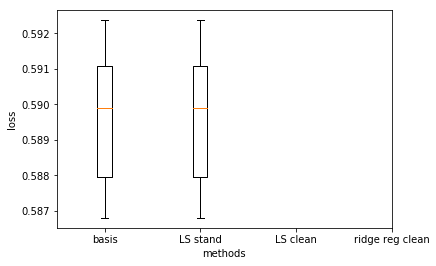

In [414]:
#basis, least_squares, ridge, GD, SGD, log_reg, reg_log_reg data cleaned * 4
plt.boxplot(logData)
plt.ylabel("loss")
plt.xlabel("methods")
plt.xticks(range(1,len(boxplotData)+1),["basis","LS stand","LS clean","ridge reg clean","ridge reg norm"])
#plt.ylim((0.26,0.36))
plt.savefig('boxplot_log.png', bbox_inches='tight')

In [334]:
logData

[[0.59058403312727092,
  0.58680345411986057,
  0.5923709676169413,
  0.58820841177176975,
  0.58920823409250633,
  0.58718521708838978,
  0.59071732125769827,
  0.59216825285236752],
 [0.59058404021774991,
  0.58680346121014992,
  0.59237097473741518,
  0.58820841883504382,
  0.58920824115712878,
  0.58718522414204011,
  0.59071732835080726,
  0.59216825997379519]]

In [392]:
boxplotData[0]=temp

In [416]:
np.mean(temp)

0.33981209179899113